In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import sys
# sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import data
import utils
import plot as plots
import evaluation
from model import WGanModel
from gan import CosmoGAN
from data import fmap
import functools
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"


/users/nperraud/default/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/users/nperraud/nati-gpu/upscale_gan_testing/plot_summary.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/python/3.6.1.1/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/python/3.6.1.1/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/users/nperraud/default/lib/python3.6/site-packages/ipykernel_launche

# Parameters

In [3]:
ns = 32
try_resume = True
Mpch=70
c = 10000
shift = 3
forward = functools.partial(fmap.stat_forward, c=c, shift=shift)
backward = functools.partial(fmap.stat_backward, c=c, shift=shift)

# Data handling

Load the data

In [4]:
dataset = data.load.load_dataset(spix=ns, resolution=256,Mpch=Mpch, forward_map=forward)

In [5]:
backward(10)

array([852800.])

min: 4.135859155152133e-10
max: 2.5526626921326794


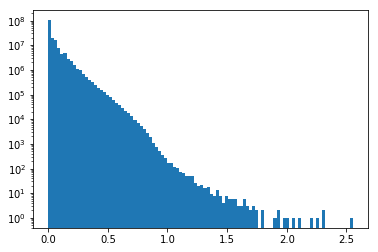

In [6]:
X = dataset.get_all_data().flatten()
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

Let us plot 16 images

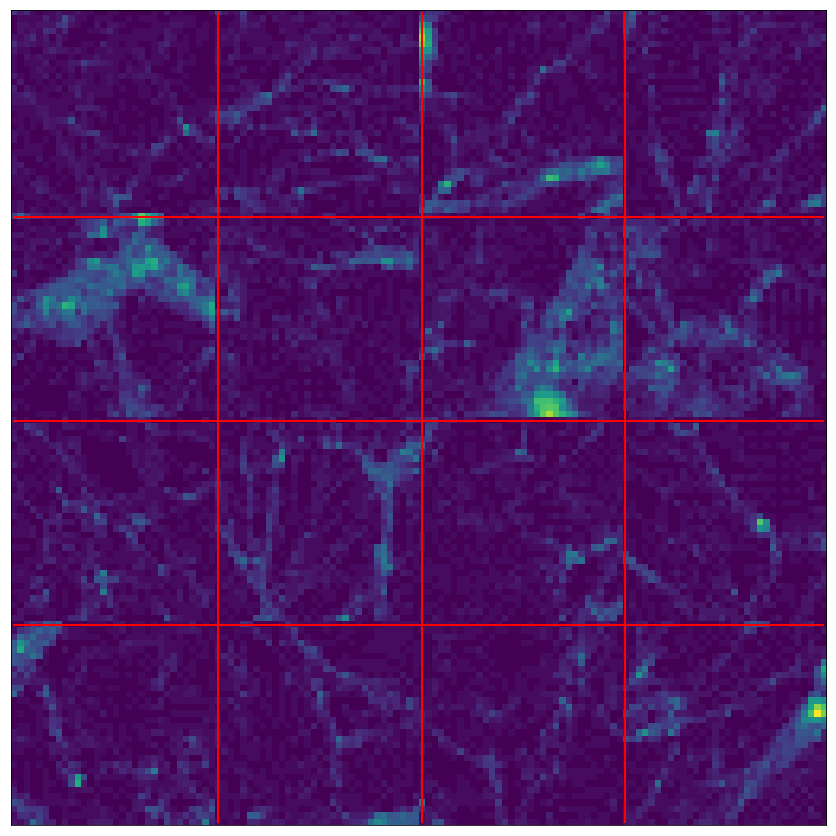

In [7]:
plt.figure(figsize=(15,15))
plots.draw_images(dataset.get_samples(N=16),nx=4,ny=4)

# A) The WGAN

In [8]:
time_str = 'stat_c_{}_shift_{}_non_lin{}'.format(c, Mpch, shift)
global_path = '/scratch/snx3000/nperraud/saved_result/'

name = 'WGAN{}'.format(ns)

## Parameters

In [9]:
bn = False

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 32]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn]
params_discriminator['full'] = [32]
params_discriminator['minibatch_reg'] = True
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 1, 1]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [32, 64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn]
params_generator['full'] = [16*16*32]
params_generator['summary'] = True
params_generator['non_lin'] = tf.nn.relu

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 16
params_optimization['gen_optimizer'] = 'rmsprop' # rmsprop / adam / sgd
params_optimization['disc_optimizer'] = 'rmsprop' # rmsprop / adam /sgd
params_optimization['disc_learning_rate'] = 3e-5
params_optimization['gen_learning_rate'] = 3e-5
params_optimization['beta1'] = 0.9
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 5


params_cosmology = dict()
params_cosmology['forward_map'] = forward
params_cosmology['backward_map'] = backward
params_cosmology['Nstats'] = 5000


params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization
params['cosmology'] = params_cosmology

params['normalize'] = False
params['image_size'] = [ns, ns]
params['prior_distribution'] = 'gaussian'
params['sum_every'] = 500
params['viz_every'] = 500
params['print_every'] = 100
params['save_every'] = 2000
params['name'] = name
params['summary_dir'] = os.path.join(global_path, params['name'] + '_' + time_str +'_summary/')
params['save_dir'] = os.path.join(global_path,params['name'] + '_' + time_str + '_checkpoints/')



In [10]:
resume, params = utils.test_resume(try_resume, params)

Resume, the training will start from the last iteration!


## Build the model

In [11]:
wgan = CosmoGAN(params, WGanModel)

Generator 
--------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 8192 outputs
         Size of the variables: (?, 8192)
     Reshape to (?, 16, 16, 32)
     1 Deconv layer with 32 channels
         Size of the variables: (?, 32, 32, 32)
     2 Deconv layer with 64 channels
         Size of the variables: (?, 32, 32, 64)
     3 Deconv layer with 1 channels
         Size of the variables: (?, 32, 32, 1)
    Costum non linearity: <function relu at 0x2aab317c0d90>
     The output is of size (?, 32, 32, 1)
--------------------------------------------------

Discriminator 
--------------------------------------------------
     The input is of size (?, 32, 32, 1)
     0 Conv layer with 16 channels
         Size of the variables: (?, 16, 16, 16)
     1 Conv layer with 32 channels
         Size of the variables: (?, 8, 8, 32)
     2 Conv layer with 32 channels
         Size of the variables: (?, 4, 4, 32)
     Reshape to (?, 512)
     3 Fu

## Train the model
Note that the input is the processed data... Maybe, we should change that

In [ ]:
wgan.train(dataset, resume=resume)

Load weights in the nework
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from /scratch/snx3000/nperraud/saved_result/WGAN32_stat_c_10000_shift_70_non_lin3_checkpoints/WGAN32-51201
Epoch: [ 0] [   0/10240] Counter:51200	( 0.2 min	168.804 examples/sec	0.09 sec/batch)	L_Disc:-0.36215535	L_Gen:4.05935669
Epoch: [ 0] [ 100/10240] Counter:51300	( 0.2 min	360.562 examples/sec	0.04 sec/batch)	L_Disc:-0.17033145	L_Gen:5.50442410
Epoch: [ 0] [ 200/10240] Counter:51400	( 0.3 min	358.646 examples/sec	0.04 sec/batch)	L_Disc:-0.09450340	L_Gen:6.18901730
Epoch: [ 0] [ 300/10240] Counter:51500	( 0.4 min	359.227 examples/sec	0.04 sec/batch)	L_Disc:-0.04775448	L_Gen:6.18845606
 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.073,1.213],	Mean [8.836E+00,8.255E+00],	Max [1.969E+03,1.332E+03],	Var [2.844E+04,3.456E+04]
 [*] [Comp, Fake, Real] PeakDistance:[5.470, 0.605, 2.717]	CrossPS:[6.227, 10.311, -1.405]
 51500 current PSD L2 425178.0288375119, logL2 14.04267896854481
 51500 current P

Epoch: [ 0] [4200/10240] Counter:55400	( 5.6 min	361.168 examples/sec	0.04 sec/batch)	L_Disc:-0.04913816	L_Gen:2.08940744
Epoch: [ 0] [4300/10240] Counter:55500	( 5.7 min	361.127 examples/sec	0.04 sec/batch)	L_Disc:-0.07134505	L_Gen:2.41758204
 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.626,1.200],	Mean [9.025E+00,7.575E+00],	Max [1.307E+03,1.216E+03],	Var [5.713E+04,2.183E+04]
 [*] [Comp, Fake, Real] PeakDistance:[4.592, 0.789, 4.001]	CrossPS:[2.648, 3.053, 7.628]
 55500 current PSD L2 32952.51032252606, logL2 1.8001000157792004
 55500 current PSD L2 32952.51032252606, logL2 1.8001000157792004, total
Epoch: [ 0] [4400/10240] Counter:55600	( 6.1 min	75.742 examples/sec	0.21 sec/batch)	L_Disc:-0.06177889	L_Gen:2.44393015
Epoch: [ 0] [4500/10240] Counter:55700	( 6.1 min	360.833 examples/sec	0.04 sec/batch)	L_Disc:-0.05257994	L_Gen:2.43409681
Epoch: [ 0] [4600/10240] Counter:55800	( 6.2 min	361.643 examples/sec	0.04 sec/batch)	L_Disc:-0.06503815	L_Gen:2.18675852
Epoch: [ 0] [4700/1024

 [*] [Fake, Real] Min [0.000, 0.000],	Median [1.014,1.256],	Mean [1.168E+01,8.795E+00],	Max [1.850E+03,1.350E+03],	Var [1.686E+05,2.574E+04]
 [*] [Comp, Fake, Real] PeakDistance:[3.103, 1.424, 3.309]	CrossPS:[-0.195, 4.308, -4.256]
 59500 current PSD L2 30168.26735489421, logL2 0.1611288553874236
 59500 current PSD L2 30168.26735489421, logL2 0.1611288553874236, total
Epoch: [ 0] [8400/10240] Counter:59600	(11.4 min	74.407 examples/sec	0.22 sec/batch)	L_Disc:-0.02007331	L_Gen:2.99168730
Epoch: [ 0] [8500/10240] Counter:59700	(11.5 min	359.918 examples/sec	0.04 sec/batch)	L_Disc:-0.03420877	L_Gen:3.09845543
Epoch: [ 0] [8600/10240] Counter:59800	(11.6 min	359.794 examples/sec	0.04 sec/batch)	L_Disc:-0.04288846	L_Gen:3.40575409
Epoch: [ 0] [8700/10240] Counter:59900	(11.6 min	359.480 examples/sec	0.04 sec/batch)	L_Disc:-0.02576373	L_Gen:3.06735563
Epoch: [ 0] [8800/10240] Counter:60000	(11.7 min	360.872 examples/sec	0.04 sec/batch)	L_Disc:-0.02718562	L_Gen:2.79003763
 [*] [Fake, Real] Mi

Epoch: [ 1] [2160/10240] Counter:63600	(16.9 min	72.318 examples/sec	0.22 sec/batch)	L_Disc:0.01493431	L_Gen:4.74220657
Epoch: [ 1] [2260/10240] Counter:63700	(17.0 min	357.492 examples/sec	0.04 sec/batch)	L_Disc:-0.05407747	L_Gen:4.93134117
Epoch: [ 1] [2360/10240] Counter:63800	(17.1 min	358.889 examples/sec	0.04 sec/batch)	L_Disc:-0.04853363	L_Gen:5.15164471
Epoch: [ 1] [2460/10240] Counter:63900	(17.1 min	359.778 examples/sec	0.04 sec/batch)	L_Disc:-0.02414680	L_Gen:5.19170523
Epoch: [ 1] [2560/10240] Counter:64000	(17.2 min	361.829 examples/sec	0.04 sec/batch)	L_Disc:-0.01716247	L_Gen:5.39348125
 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.545,1.235],	Mean [6.524E+00,7.614E+00],	Max [1.246E+03,1.151E+03],	Var [5.859E+04,2.042E+04]
 [*] [Comp, Fake, Real] PeakDistance:[2.611, 1.646, 3.543]	CrossPS:[1.485, 1.471, 3.041]
 64000 current PSD L2 11427.503725294277, logL2 0.11056124067001026
 64000 current PSD L2 11427.503725294277, logL2 0.11056124067001026, total
Model saved!
Epoch:

Epoch: [ 1] [6360/10240] Counter:67800	(22.6 min	360.543 examples/sec	0.04 sec/batch)	L_Disc:-0.01234646	L_Gen:5.93049526
Epoch: [ 1] [6460/10240] Counter:67900	(22.6 min	361.016 examples/sec	0.04 sec/batch)	L_Disc:0.05141077	L_Gen:5.53286791
Epoch: [ 1] [6560/10240] Counter:68000	(22.7 min	359.465 examples/sec	0.04 sec/batch)	L_Disc:0.00618791	L_Gen:5.88945341
 [*] [Fake, Real] Min [0.000, 0.000],	Median [1.547,1.230],	Mean [7.865E+00,8.534E+00],	Max [1.156E+03,1.443E+03],	Var [2.274E+04,3.766E+04]
 [*] [Comp, Fake, Real] PeakDistance:[2.803, 0.918, 2.379]	CrossPS:[3.991, -4.251, -1.930]
 68000 current PSD L2 34171.69209352292, logL2 0.5570532537646405
 68000 current PSD L2 34171.69209352292, logL2 0.5570532537646405, total
Model saved!
Epoch: [ 1] [6660/10240] Counter:68100	(23.1 min	63.782 examples/sec	0.25 sec/batch)	L_Disc:-0.00416325	L_Gen:5.75538254
Epoch: [ 1] [6760/10240] Counter:68200	(23.2 min	360.873 examples/sec	0.04 sec/batch)	L_Disc:-0.03207213	L_Gen:5.85194159
Epoch: [ 

Epoch: [ 2] [ 320/10240] Counter:72000	(28.3 min	360.123 examples/sec	0.04 sec/batch)	L_Disc:0.00050826	L_Gen:5.36977005
 [*] [Fake, Real] Min [0.000, 0.000],	Median [1.700,1.254],	Mean [7.865E+00,7.772E+00],	Max [1.231E+03,1.179E+03],	Var [3.438E+04,1.916E+04]
 [*] [Comp, Fake, Real] PeakDistance:[3.451, 1.309, 3.456]	CrossPS:[2.392, -0.858, -0.881]
 72000 current PSD L2 96167.75270821131, logL2 1.6881802311376455
 72000 current PSD L2 96167.75270821131, logL2 1.6881802311376455, total
Model saved!
Epoch: [ 2] [ 420/10240] Counter:72100	(28.8 min	62.592 examples/sec	0.26 sec/batch)	L_Disc:0.01476043	L_Gen:5.55515909
Epoch: [ 2] [ 520/10240] Counter:72200	(28.8 min	358.294 examples/sec	0.04 sec/batch)	L_Disc:-0.04902137	L_Gen:5.73134708


In [ ]:
gen_sample, gen_sample_raw = wgan.generate(N=2000)
gen_sample = np.squeeze(gen_sample)
gen_sample_raw = np.squeeze(gen_sample_raw)

In [ ]:
plt.figure(figsize=(15,15))
plots.draw_images(gen_sample,nx=4,ny=4)

In [ ]:
raw_images = backward(dataset.get_samples(dataset.N))

In [ ]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(raw_images, gen_sample_raw)

In [ ]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(raw_images, gen_sample_raw)

In [ ]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(raw_images, gen_sample_raw)